## Domanda Teorica

Descrivere con proprie parole (not CHAT-GPT oriented) il concetto di time series forecasting e cosa lo differenzia dai problemi ri regressione standard, fornendo esempi ed applicazioni/limiti.

## Fake news Detection

La time series forecasting è una tecnica di ML usata per fare previsioni. A differenza della classica linear regression, l'ordine è importantissimo, inoltre il tempo deve essere settato come index. A questo punto devo fare un test di auto-correlazione per capire se una determinata variabile è correlata con il tempo.

In [1]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Fake.csv
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/True.csv
path_fake = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Fake.csv'
path_true = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/True.csv'

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_fake = pd.read_csv(path_fake)
df_true = pd.read_csv(path_true)
df_fake["class"] = 0 #fake
df_true["class"] = 1 #real

df_marge = pd.concat([df_fake, df_true], axis =0 )
df = df_marge.drop(["title", "subject","date"], axis = 1)
df = df.sample(frac = 1).reset_index(drop=True)
df

,text,class
0,A shocking victory 53% LEAVE 47% STAYIt was a...,0
1,Here s how fake news works In an effort to cas...,0
2,,0
3,(Reuters) - A British tourist who caused a sec...,1
4,"Former CIA Agent, Clare Lopez has been ringing...",0
...,...,...
44893,"Yesterday, 70-year-old Donald Trump resorted t...",0
44894,(Reuters) - President Donald Trump is consider...,1
44895,"Only one day ago, FOX News published a factual...",0
44896,WASHINGTON (Reuters) - U.S. Attorney General J...,1


In [4]:
df['class'] = df['class'].replace({0: 'fake', 1: 'real'})
df

,text,class
0,A shocking victory 53% LEAVE 47% STAYIt was a...,fake
1,Here s how fake news works In an effort to cas...,fake
2,,fake
3,(Reuters) - A British tourist who caused a sec...,real
4,"Former CIA Agent, Clare Lopez has been ringing...",fake
...,...,...
44893,"Yesterday, 70-year-old Donald Trump resorted t...",fake
44894,(Reuters) - President Donald Trump is consider...,real
44895,"Only one day ago, FOX News published a factual...",fake
44896,WASHINGTON (Reuters) - U.S. Attorney General J...,real


In [6]:
# STEP1 DEFINIRE ED APPLICARE LA REGEX
patterns = {
            r'\d+': '',             # remove digits (numeri)
            r'[^\w\s]': '',         # remove punteggiatura e simboli ...,'@!£$%
            r'\b\w{1,2}\b':'',      # remove all token less than2 characters
            r'(http|www)[^\s]+':'', # remove website
            r'\s+': ' '             # sostituisce tutti i multipli spazi con uno spazio
            }

def clean_column(df, column, patterns):
    for pattern, replacement in patterns.items():
        df[column] = df[column].str.replace(pattern, replacement)
        df[column] = df[column].str.lower() # applica il lower
    return df

#solo in preview
clean_column(df, 'text', patterns)

,text,class
0,shocking victory leave stayit was three ocloc...,fake
1,here how fake news works effort cast president...,fake
2,,fake
3,reuters british tourist who caused security sc...,real
4,former cia agent clare lopez has been ringing ...,fake
...,...,...
44893,yesterday yearold donald trump resorted acting...,fake
44894,reuters president donald trump considering add...,real
44895,only one day ago fox news published factual st...,fake
44896,washington reuters attorney general jeff sessi...,real


In [7]:
# controllo eventuali valori nulli
df.isnull().sum()

text     0
class    0
dtype: int64

In [9]:
# applichiamo la regex
df = clean_column(df, 'text', patterns)
df

,text,class
0,shocking victory leave stayit was three ocloc...,fake
1,here how fake news works effort cast president...,fake
2,,fake
3,reuters british tourist who caused security sc...,real
4,former cia agent clare lopez has been ringing ...,fake
...,...,...
44893,yesterday yearold donald trump resorted acting...,fake
44894,reuters president donald trump considering add...,real
44895,only one day ago fox news published factual st...,fake
44896,washington reuters attorney general jeff sessi...,real


In [12]:
fake = df[df['class']=="fake"]['text']
real = df[df['class']=="real"]['text']

In [15]:
# creo text fake per la word cloud
textfake = list(map(str, fake))
textfake = ''.join(textfake)

In [16]:
# creo text real per la word cloud
textreal = list(map(str, real))
textreal = ''.join(textreal)


(-0.5, 799.5, 399.5, -0.5)

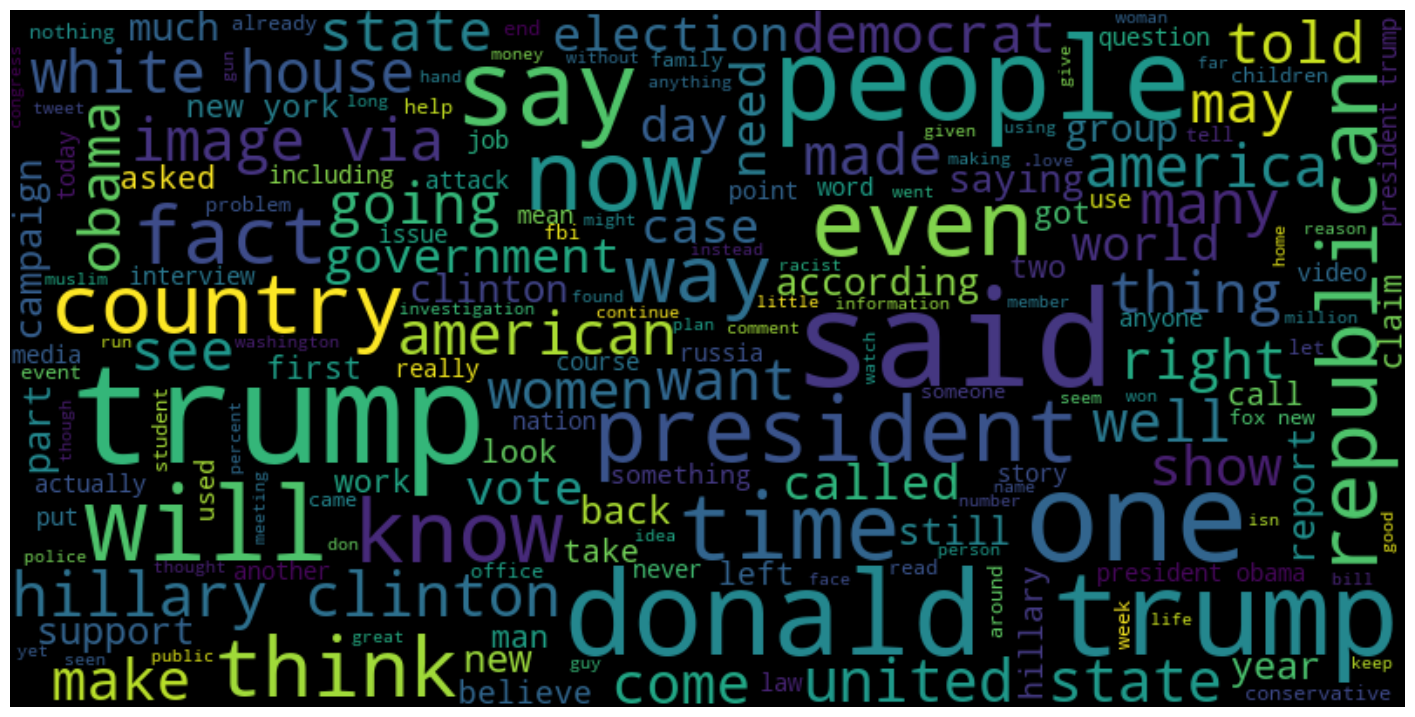

In [17]:
## STEP 2 : EDA con WORDCLOUD
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      stopwords = STOPWORDS, random_state = 667)

wordcloud.generate(textfake)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 799.5, 399.5, -0.5)

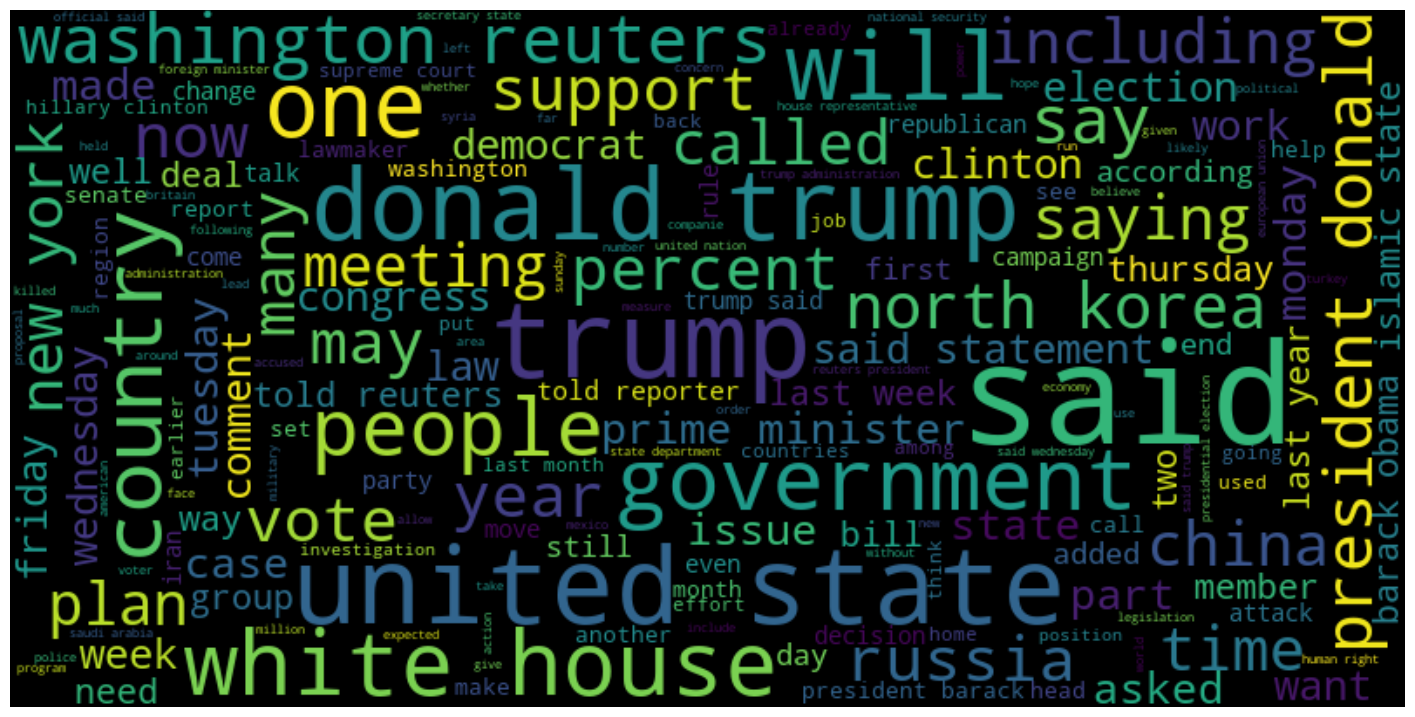

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      stopwords = STOPWORDS, random_state = 667)

wordcloud.generate(textreal)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [19]:
##STEP 3: Definizre X e y (features testuali e Target)

X = df['text']
y = df['class']

In [21]:
##STEP 4: Vettorizzazione
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
#vectorizer = CountVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X).toarray()
X_vect

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 2, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
##STEP 5: TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_tfidf = tfidfconverter.fit_transform(X_vect).toarray()
X_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.03544253, ..., 0.04211236, 0.        ,
        0.03142742],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
##STEP 6: Split Training and Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y,
                                                    test_size=0.3, 
                                                    random_state=667
                                                    )

In [26]:
##STEP 7: Modellazione
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train) 

# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
test_data_accuracy


0.9325167037861916

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
test_data_accuracy

0.9834446919079436

In [28]:
# scelgo la random forest per avere maggiore accuracy
# stampo la classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.99      0.98      0.98      7132
        real       0.97      0.99      0.98      6338

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



Text(95.72222222222221, 0.5, 'Actual')

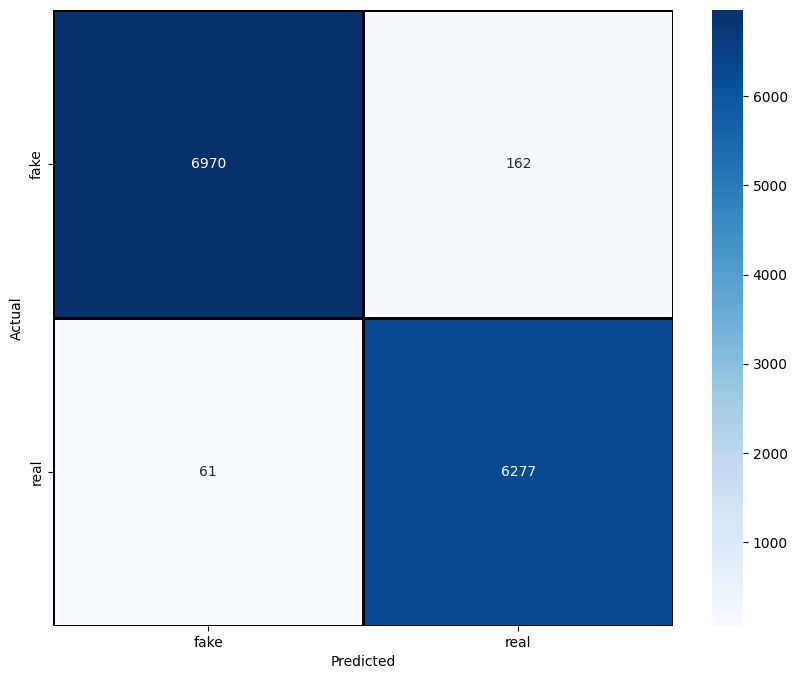

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = classifier.classes_, 
            yticklabels = classifier.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [31]:
# Step 8: Pipeline Finale (nuovo train test split su dati raw tetuali)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=667
                                                    )


from sklearn.pipeline import Pipeline

bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
clf = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)

pipe = Pipeline([
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',clf),
                ])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9806236080178173


In [33]:
# Step 10: Cross Validation
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(pipe, X, y, scoring = 'f1_micro', cv = 8)

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

scores=[0.98735079 0.98806342 0.98307199 0.98645759 0.98467569 0.98592302
 0.98467569 0.98449751]
mean=0.9855894642236057
std=0.0015527261257766364


In [34]:
# salvo il modello

import joblib
joblib.dump(pipe,'NLPEs1.pkl')

['NLPEs1.pkl']

In [44]:
# carico e testo la predict

import joblib

uploaded_model = joblib.load('NLPEs1.pkl')
pred = uploaded_model.predict([df["text"][3]]) 
pred[0]

'real'